In [1]:
# standard modules
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import importlib

# PyTorch modules
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# (f)MRI modules
# import nibabel as nib
# import nilearn.image as nimg
# import nilearn.plotting as nplot
# import bids

# import data + model modules
import ukbb_data
import ukbb_ica_models
# in case of changes 
importlib.reload(ukbb_data)
importlib.reload(ukbb_ica_models)

# import custom functions
import utils
# in case of changes
importlib.reload(utils)

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# prepare data paths
ukbb_dir = '/ritter/share/data/UKBB/ukb_data/'

In [3]:
torch.cuda.is_available()

True

# Approach 1: Dataset + manual loader implementation

In [10]:
g = torch.Generator()
g.manual_seed(43)

# initialise UKBB data
data = ukbb_data.UKBBDataset(ukbb_dir, all_data=False)
print(f'Available ICA25 data: {len(data)}')

# create train/test split samplers
batch_size = 10 #128
split_ratio = 0.8
## create indices
dataset_size = len(data)
indices = list(range(dataset_size))
split_index = int(np.floor(split_ratio * dataset_size))
## shuffle
np.random.seed(43)
np.random.shuffle(indices)
## get list of split indices, feed to samplers
train_idx, test_idx = indices[:split_index], indices[split_index:]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# load train/test data
train_loader = DataLoader(
                data,
                batch_size=batch_size,
                sampler=train_sampler,
                # drop_last=False,
                worker_init_fn=utils.seed_worker,
                generator=g,
                )
test_loader = DataLoader(
                data,
                batch_size=batch_size,
                sampler=test_sampler,
                # drop_last=False,
                worker_init_fn=utils.seed_worker,
                generator=g,
                )

Available ICA25 data: 100


In [11]:
data[0]

(tensor([[-1.8139, -1.8822, -2.0016,  ...,  0.4351,  0.3960,  0.4140],
         [ 3.3147,  2.3325,  1.8756,  ..., -0.2754, -0.6240, -0.4226],
         [ 1.2176,  0.6892,  0.6464,  ..., -1.2722, -1.1196, -0.7218],
         ...,
         [ 1.8535,  1.8548,  1.7175,  ..., -0.9533, -1.1425, -1.0926],
         [ 3.0506,  1.7800,  2.1955,  ..., -1.5257, -1.1038, -1.5390],
         [ 2.7041,  1.8542,  2.6583,  ..., -0.9206, -0.4617, -1.1548]]),
 tensor(61.))

In [12]:
# initialise model
simple_CNN = ukbb_ica_models.simple1DCNN()

# initialise trainer
trainer = pl.Trainer(accelerator='auto',
                     devices=1 if torch.cuda.is_available() else None,
                     max_epochs=2, ## which number would be good?
                     # callbacks=,
                     deterministic=True)

# train the model
trainer.fit(simple_CNN, train_loader) 

# test the model
trainer.test(simple_CNN, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type       | Params
---------------------------------------
0 | act     | ReLU       | 0     
1 | loss    | MSELoss    | 0     
2 | conv1   | Conv1d     | 4.0 K 
3 | conv2   | Conv1d     | 10.3 K
4 | conv3   | Conv1d     | 41.1 K
5 | conv4   | Conv1d     | 164 K 
6 | maxpool | MaxPool1d  | 0     
7 | model   | Sequential | 225 K 
---------------------------------------
225 K     Trainable params
0         Non-trainable params
225 K     Total params
0.903     Total estimated model params size (MB)
/home/laurar/anaconda3/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/laurar/anaconda3/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            3604.186279296875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 3604.186279296875}]

In [13]:
trainer.test(simple_CNN, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            3604.186279296875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 3604.186279296875}]

# Approach 2: Dataset + DataModule

In [4]:
! gpustat

cuda02                      Thu Jun  1 11:44:30 2023  470.182.03
[0] NVIDIA GeForce RTX 3090 | 28'C,   0 % |  4204 / 24268 MB | tomasz(2873M) tjade(1323M) gdm(4M)
[1] NVIDIA GeForce RTX 3090 | 30'C,   0 % |     8 / 24268 MB | gdm(4M)
[2] NVIDIA GeForce RTX 3090 | 27'C,   0 % |     8 / 24268 MB | gdm(4M)
[3] NVIDIA GeForce RTX 3090 | 60'C,  81 % | 16536 / 24268 MB | tjade(14029M) tjade(2499M) gdm(4M)


## Initial model

In [8]:
# determine dirpath
path = 'ICA25/Initial1DCNN/'
# initialise model
simple_CNN = ukbb_ica_models.simple1DCNN()

# initialise logger
logger = CSVLogger(save_dir=path, name='Logs')

# set callbacks
early_stopping = EarlyStopping(monitor='val_loss')

checkpoint = ModelCheckpoint(dirpath=path+'Checkpoint/',
                             filename='models-{epoch:02d}-{val_loss:.2f}',
                             monitor='val_loss',
                             save_top_k=1,
                             mode='min')

# initialise trainer
trainer = pl.Trainer(accelerator='gpu',
                     devices=[2],
                     max_epochs=500, ## which number would be good?
                     logger=logger,
                     log_every_n_steps=10,
                     callbacks=[early_stopping, checkpoint],
                     deterministic=True)

# initialise DataModule
data = ukbb_data.UKBBDataModule(ukbb_dir)

# save info on which data was used + what the train/val/test split was
utils.save_data_info(path=path, datamodule=data)

# train model
trainer.fit(simple_CNN, datamodule=data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/laurar/ICA25/Initial1DCNN/Checkpoint exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type       | Params
---------------------------------------
0 | act     | ReLU       | 0     
1 | loss    | MSELoss    | 0   

Sanity Checking: 0it [00:00, ?it/s]

/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [9]:
trainer.test(simple_CNN, datamodule=data)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/laurar/anaconda3/envs/cuda02/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           40.848453521728516
        test_mae            5.2684478759765625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 40.848453521728516, 'test_mae': 5.2684478759765625}]

,train_loss,step,val_loss,val_mae,test_loss,test_mae
epoch,,,,,,
0,3855.608887,9,NaN,NaN,NaN,NaN
0,3671.917969,19,NaN,NaN,NaN,NaN
0,2776.071777,29,NaN,NaN,NaN,NaN
0,NaN,36,1048.853516,31.476728,NaN,NaN
1,664.630981,39,NaN,NaN,NaN,NaN


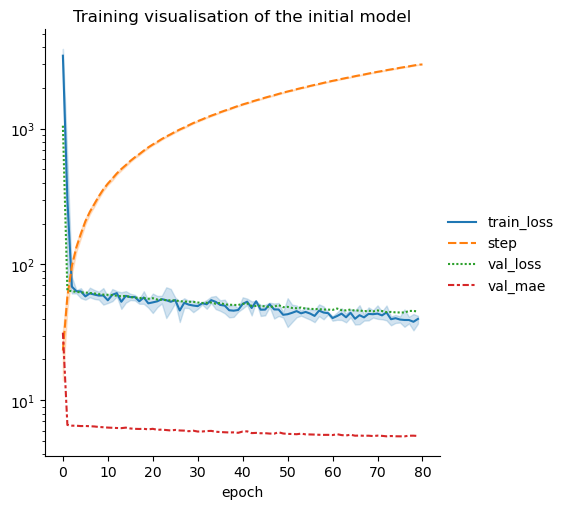

In [86]:
metrics = utils.get_metrics(trainer, show=True)
utils.plot_training(data=metrics, title='Training visualisation of the initial model')